In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

###
# Recreation of Jegadessh and Titan's (1993) momentum strategy
# Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency
# based on current stock price data.
# This script implements a momentum-based trading strategy using stock price data.
# The strategy involves:
# 1. Loading stock price data from CSV files.
# 2. Calculating daily returns and future returns.
# 3. Rebalancing portfolios monthly based on momentum.
# 4. Evaluating the performance of the strategy.
# 5. Visualizing the results.
###

# Parameters
lookback_days = 63  # Approx. 3 months (J=3)
holding_days = 63   # Approx. 3 months (K=3)
data_dir = Path("stock_info")
price_data = {}

# Load stock price data
for file in data_dir.glob("*.csv"):
    try:
        df = pd.read_csv(file, parse_dates=["Date"])
        df["Close/Last"] = df["Close/Last"].replace('[\$,]', '', regex=True).astype(float)
        df = df.sort_values("Date").set_index("Date")
        price_data[file.stem] = df["Close/Last"]
    except Exception as e:
        print(f"Failed to load {file.name}: {e}")

# Combine price data
prices = pd.DataFrame(price_data)
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()

# Align to business days and fill missing values
prices = prices.asfreq("B")
prices = prices.interpolate(method="linear", limit_direction="both")
prices = prices.dropna(axis=1, thresh=int(0.8 * len(prices)))  # Drop stocks with too much missing data

# Calculate returns
returns = prices.pct_change().dropna()
future_returns = prices.pct_change(periods=holding_days).shift(-holding_days)

# Rebalance dates (monthly, starting after lookback window)
rebalance_dates = returns.index[lookback_days:-holding_days]
rebalance_dates = rebalance_dates[rebalance_dates.is_month_end]

# Store active portfolios and their returns
active_portfolios = []
portfolio_returns = defaultdict(list)

<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
C:\Users\NickPC\AppData\Local\Temp\ipykernel_31964\4286379019.py:18: SyntaxWarning: invalid escape sequence '\$'
  df["Close/Last"] = df["Close/Last"].replace('[\$,]', '', regex=True).astype(float)


In [77]:
for date in rebalance_dates:
    lookback_start = date - pd.Timedelta(days=lookback_days * 2)
    lookback_window = returns.loc[lookback_start:date]

    if len(lookback_window) < lookback_days:
        print(f"Skipping {date.date()}: not enough lookback data.")
        continue

    try:
        past_price = prices.loc[date - pd.Timedelta(days=lookback_days)]
        current_price = prices.loc[date]
        momentum_scores = (current_price / past_price) - 1
        momentum_scores = momentum_scores.dropna()

        ranked = momentum_scores.rank(pct=True)
        deciles = pd.qcut(ranked, 10, labels=False)

        future_date = date + pd.Timedelta(days=holding_days)
        if future_date not in future_returns.index:
            print(f"Skipping {date.date()}: future return not available.")
            continue

        for decile in range(10):
            stocks = momentum_scores.index[deciles == decile]
            if len(stocks) == 0:
                continue

            active_portfolios.append({
                "start_date": date,
                "end_date": future_date,
                "decile": decile + 1,
                "stocks": stocks
            })

        # Calculate active portfolio returns at this date
        for port in active_portfolios[:]:
            if date >= port["end_date"]:
                active_portfolios.remove(port)
                continue

            valid_stocks = [s for s in port["stocks"] if s in future_returns.columns]
            if not valid_stocks or date not in future_returns.index:
                continue

            daily_return = future_returns.loc[date, valid_stocks].mean()
            portfolio_returns[(date, port["decile"])].append(daily_return)

    except Exception as e:
        print(f"Error on {date.date()}: {e}")

# Average overlapping returns
final_data = []
for (date, decile), rets in portfolio_returns.items():
    final_data.append({
        "Date": date,
        "Decile": decile,
        "Return": np.mean(rets)
    })

portfolio_df = pd.DataFrame(final_data)

Path("output").mkdir(parents=True, exist_ok=True)
portfolio_df.to_csv("output/momentum_portfolio_returns.csv", index=False)

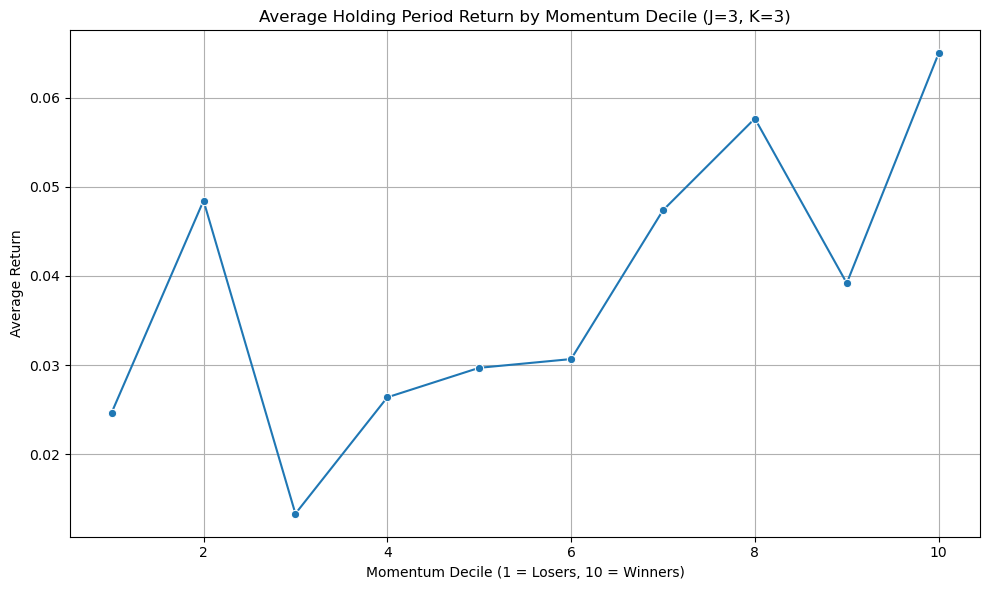

In [78]:
# Plot average return per decile
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=portfolio_df.groupby("Decile")["Return"].mean().reset_index(),
    x="Decile", y="Return", marker="o"
)
plt.title("Average Holding Period Return by Momentum Decile (J=3, K=3)")
plt.xlabel("Momentum Decile (1 = Losers, 10 = Winners)")
plt.ylabel("Average Return")
plt.grid(True)
plt.tight_layout()
plt.show()

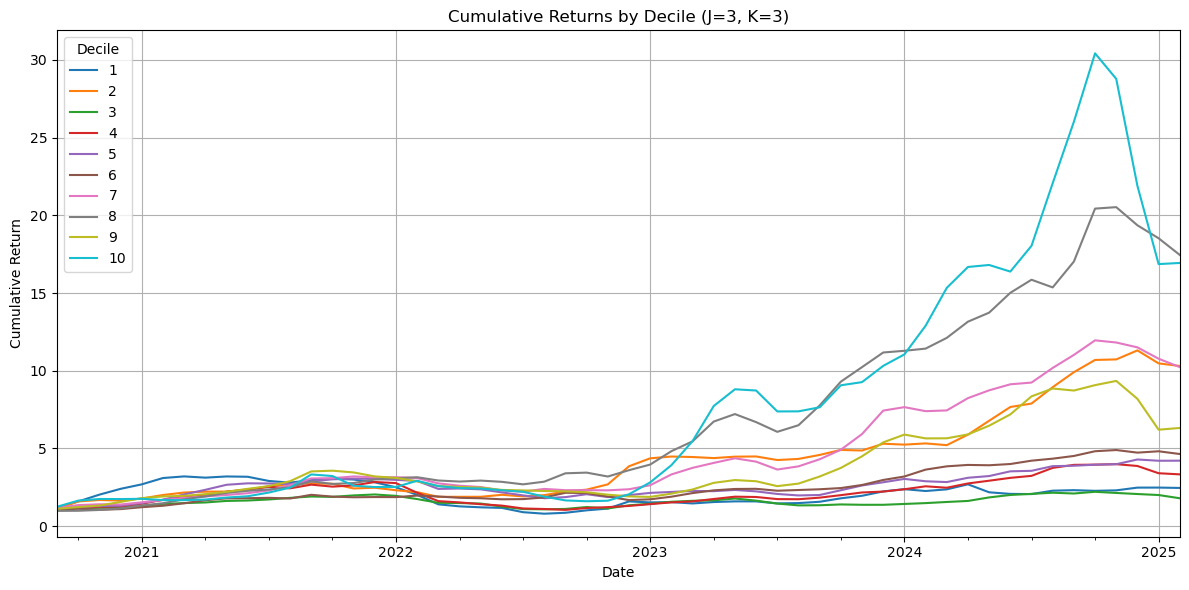

In [79]:
# Plot cumulative returns by decile
cumulative_returns = (
    portfolio_df.pivot(index="Date", columns="Decile", values="Return")
    .fillna(0)
    .add(1).cumprod()
)

cumulative_returns.plot(figsize=(12, 6), colormap="tab10")
plt.title("Cumulative Returns by Decile (J=3, K=3)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.legend(title="Decile")
plt.tight_layout()
plt.show()

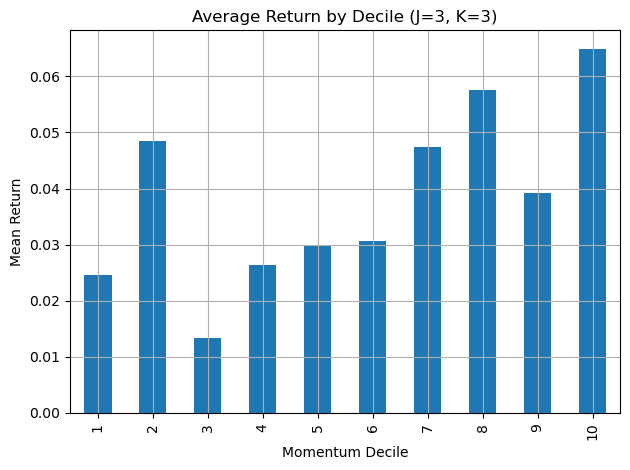

In [80]:
portfolio_df.groupby("Decile")["Return"].mean().plot(kind="bar")
plt.title("Average Return by Decile (J=3, K=3)")
plt.ylabel("Mean Return")
plt.xlabel("Momentum Decile")
plt.grid(True)
plt.tight_layout()
plt.show()

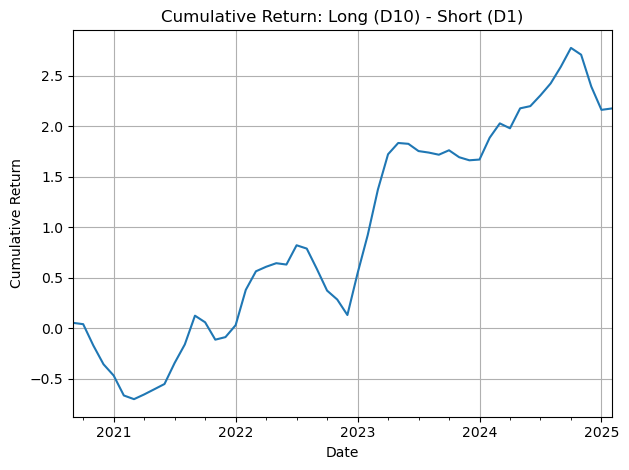

In [81]:
pivot = portfolio_df.pivot(index="Date", columns="Decile", values="Return")
pivot['LongShort'] = pivot[10] - pivot[1]
pivot['LongShort'].cumsum().plot()
plt.title("Cumulative Return: Long (D10) - Short (D1)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()